In [6]:
import numpy as np
import pickle
import re
import tensorflow as tf

In [7]:
fb = pickle.load(open("/home/markus/dep/dep_data/bases/fb.pickle","rb"))
fs = pickle.load(open("/home/markus/dep/dep_data/bases/fs.pickle","rb"))
sd = pickle.load(open("/home/markus/dep/dep_data/bases/sd.pickle", "rb"))
zero = [np.zeros(fb[0].shape),np.zeros(fb[1].shape), np.zeros(fb[2].shape)]

bases = {"fb": fb, "fs": fs, "sd": sd, "zero": zero}

In [8]:
active_motors = [1,3,4,5,10,12]

In [9]:
# need to load dep matrix
def loadDepMatrix(filename):
    file_ = "../dep_matrices/"+filename
    f = open(file_,"rb")
    text = f.read()
    f.close()
    matrix = np.array([np.array(re.split(",", row.strip(","))).astype(float) for row in re.split("NEW_ROW", text.strip(",NEW_ROW,"))])
    return matrix

In [10]:
# need function that does DEP calculation from input to output

with tf.name_scope("input"):
    input_ = tf.placeholder(tf.float32, [None,28], name="input") #differential sensors
with tf.name_scope("weights"):
    weights = tf.placeholder(tf.float32, [None,14,28], name="weights")
with tf.name_scope("output"):
    in_ = tf.reduce_sum(weights*input_,axis=2)
    out_ = tf.tanh(in_)
    #out_ = tf.sigmoid(in_)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

def dep_out(sensors, matrix):
    out = sess.run(out_,{input_: sensors, weights: matrix})
    return out

### Plotting

In [11]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [12]:
def plot_data(data):
    color_pallette = ['#2274A5', '#B4656F', '#4E937A', '#F3D34A', '#A11692', '#F75C03', '#F1C40F', '#D90368', '#00CC66', '#540B0E', '#2274A5', '#B4656F', '#4E937A', '#F3D34A']
    motor_to_muscle = [0, 1, 0, 2, 6, 5, 0, 0, 0, 0, 4, 0, 3, 0]

    for motor in range(data[0,:].size):
        if motor_to_muscle[motor] == 0:
            # motor not connected
            continue
        plt.figure(1)
        plt.plot(data[:,motor],color=color_pallette[motor], linewidth=1.0, label="Muscle "+str(motor_to_muscle[motor]))

    # configure plots
    fontP = FontProperties()
    fontP.set_size('small')
    plt.figure(1)
    plt.ylabel("Motor position (rad)")
    plt.xlabel("Time (s)")
    plt.legend(loc="lower center", mode="expand", ncol=6, prop=fontP)
    plt.show()

### Verify dep_out

In [8]:
filename = "front_back.dep"
matrix = loadDepMatrix(filename).reshape(1,14,28)

In [11]:
# Let's test the dep calculation by running through a full behavior, plotting its output to make sure it is working properly
data = []
d = 50
for t in range(bases["fb"][0].shape[0]):
    pos = bases["fb"][0][t]/100000.
    force = (bases["fb"][2][t]*0.2375-5)/300.
    pos_delayed = bases["fb"][0][t-d]/100000.
    force_delayed = (bases["fb"][2][t-d]*0.2375-5)/300.
    sensors = np.append(pos+force,pos_delayed+force_delayed).reshape(1,28)
    out = dep_out(sensors,matrix).reshape(14,)
    data.append(out)
data = np.array(data)

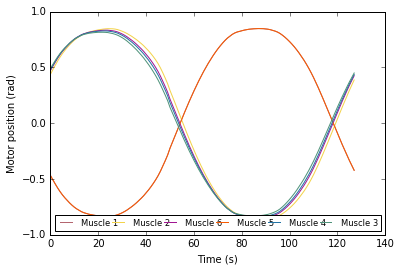

In [12]:
plot_data(data)

In [ ]:
# Seems to working reasonably

### DEP matrix with wrong behavior

In [33]:
filename = "front_back.dep"
matrix = loadDepMatrix(filename).reshape(1,14,28)

In [34]:
# What happens when you feed the sensory data from a different behavior through
data = []
d = 50
for t in range(bases["fs"][0].shape[0]):
    pos = bases["fs"][0][t]/100000.
    force = (bases["fs"][2][t]*0.2375-5)/300.
    pos_delayed = bases["fs"][0][t-d]/100000.
    force_delayed = (bases["fs"][2][t-d]*0.2375-5)/300
    sensors = np.append(pos+force,pos_delayed+force_delayed).reshape(1,28)
    out = dep_out(sensors,matrix).reshape(14,)
    data.append(out)
data = np.array(data)

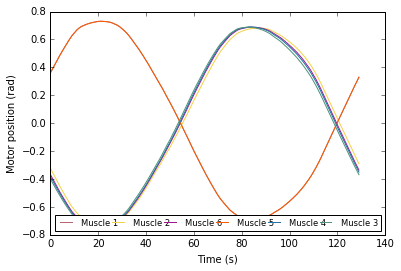

In [35]:
plot_data(data)

### Loop through dep matrix with sine waves

In [39]:
steps = 100
sines = [np.sin(np.arange(steps)*2*np.pi/steps+i*2*np.pi/28) for i in range(28)]

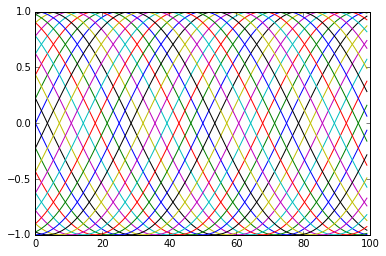

In [40]:
for sine in sines:
    plt.plot(sine)
plt.show()

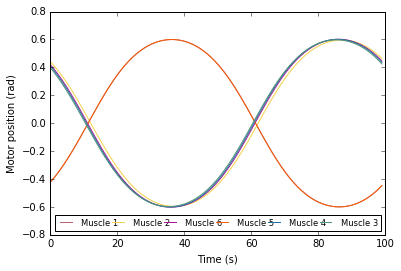

In [49]:
filename = "front_back.dep"
matrix = loadDepMatrix(filename).reshape(1,14,28)
data_fb = np.array([dep_out(sensors.reshape(1,28),matrix).reshape(14,) for sensors in np.array(sines).T])
plot_data(data_fb)

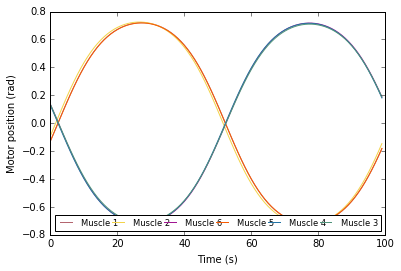

In [54]:
filename = "front_side.dep"
matrix = loadDepMatrix(filename).reshape(1,14,28)
data_fb = np.array([dep_out(sensors.reshape(1,28),matrix).reshape(14,) for sensors in np.array(sines).T])
plot_data(data_fs)

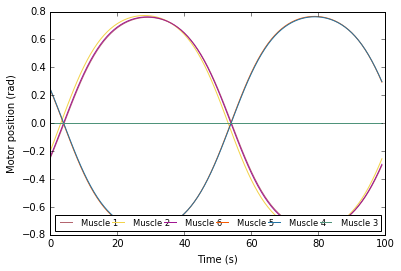

In [56]:
filename = "side_down.dep"
matrix = loadDepMatrix(filename).reshape(1,14,28)
data_fb = np.array([dep_out(sensors.reshape(1,28),matrix).reshape(14,) for sensors in np.array(sines).T])
plot_data(data_sd)

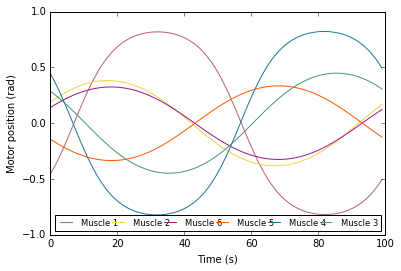

In [41]:
filename = "front_back.dep"
matrix_fb = loadDepMatrix(filename).reshape(1,14,28)
filename = "side_down.dep"
matrix_sd = loadDepMatrix(filename).reshape(1,14,28)
matrix = 0.7*matrix_fb + 0.7*matrix_sd
data_mix = np.array([dep_out(sensors.reshape(1,28),matrix).reshape(14,) for sensors in np.array(sines).T])
plot_data(data_mix)

In [ ]:
motor_to_muscle = [0, 1, 0, 2, 6, 5, 0, 0, 0, 0, 4, 0, 3, 0

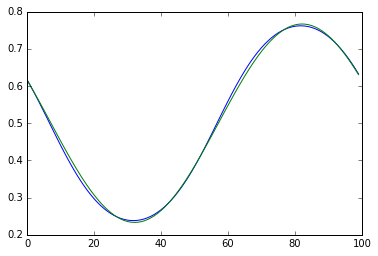

In [102]:
# this is with sigmoid activation functiono
plt.figure(1)
plt.plot(data_mix[:,10])
plt.plot((sines[12]/3.75+0.5))
plt.show()

### DEP memory ideas

In [106]:
# DEP Memory bank

# Storage:
# Stack DEP matrices in one neural network: use dep learning rule to store a new memory in the memory neural network i.e. once a memory is decided to be kept,
# loop through that behavior again reading the input/output and running the dep learning rule on the memory network with
# the obtained inputs

# this will run into issue of matrices cancelling each other out do to negative weight representation
# it may be possible to circumvent this by using a 0/1 encoding

# issues of memory confusion with such a hebbian learning rule can be overcome by using a sparse distributed representation

# Recall:
# For such a storage how do we retrieve an individual pattern?


In [ ]:
# DEP quantized weights
# Storage:

# Have network which splits each regular weight into various weights at a given resolution, where a given DEP matrix must
# be transformed into a selection of the correct node

# Must infer DEP matrix values and use them in a sparse distributed representation as the output for a hebbian learning network
# mapping an id to DEP matrix selection

### DEP store and recall weights

In [13]:
filename = "front_back.dep"
matrix = loadDepMatrix(filename).reshape(1,14,28)
sensors = []
for i in range(28):
    sensor = np.zeros((1,28))
    sensor[0,i] = 1
    sensors.append(sensor)

In [28]:
dep = np.zeros((1,14,28))

In [29]:
for sensor in sensors:
    dep += np.tanh(matrix*sensor)

In [33]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [36]:
#dep-matrix

In [37]:
# so what about a network that would automatically generate such an input "scan"?

# nodes connected by +1 to left, -1 to right with last one not connected to anything, feed 1 to start and recursively go
# through until finnish 

### Improving transitions via feeding correct data through sensory delay channels

In [8]:
filename = "front_back.dep"
matrix_fb = loadDepMatrix(filename).reshape(1,14,28)

In [9]:
filename = "side_down.dep"
matrix_sd = loadDepMatrix(filename).reshape(1,14,28)

In [31]:
dep = DEP()

In [32]:
# front back behavior with feeding output back to input
# sensor delay channel has behavior from 50 timesteps backwards i.e. 1 second

d = 50
pos_delayed = bases["fb"][0][-d:]/100000.
force_delayed = (bases["fb"][2][-d:]*0.2375-5)/300.
in_delayed = list((pos_delayed+force_delayed))

data = []
pos = bases["fb"][0][0]/100000.
force = (bases["fb"][2][0]*0.2375-5)/300.
in_ = pos+force
matrix = matrix_fb
for t in range(bases["fb"][0].shape[0]):
    sensors = np.append(in_,in_delayed[0]).reshape(1,28)
    in_ = dep.dep_out(sensors,matrix).reshape(14,)
    in_delayed.pop(0)
    in_delayed.append(in_)
    data.append(in_)
data = np.array(data)

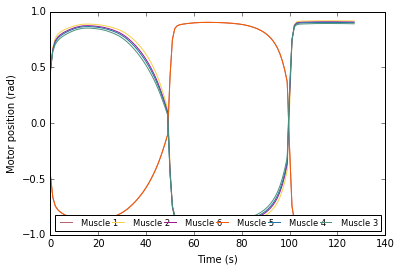

In [33]:
plot_data(data)

In [34]:
# front back behavior with swap from fb matrix to sd matrix at t = 50
# at this point the sensory delay channel has the output from when the fb behavior started until the switching moment
pos_delayed = bases["fb"][0][-d:]/100000.
force_delayed = (bases["fb"][2][-d:]*0.2375-5)/300.
in_delayed = list((pos_delayed+force_delayed))

data = []
pos = bases["fb"][0][0]/100000.
force = (bases["fb"][2][0]*0.2375-5)/300.
in_ = pos+force
matrix = matrix_fb
for t in range(bases["fb"][0].shape[0]):
    if t == 50:
        matrix = matrix_sd
    sensors = np.append(in_,in_delayed[0]).reshape(1,28)
    in_ = dep_out(sensors,matrix).reshape(14,)
    in_delayed.pop(0)
    in_delayed.append(in_)
    data.append(in_)
data = np.array(data)

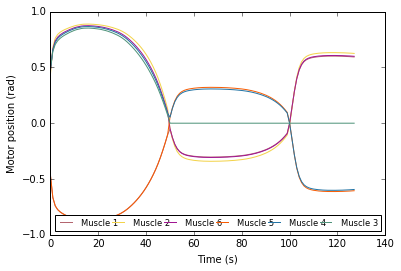

In [35]:
plot_data(data)

In [40]:
# front back behavior with swap from fb matrix to sd matrix at t = 50
# and swap of the sensory delay channel data to a sd behavior history
pos_delayed = bases["fb"][0][-d:]/100000.
force_delayed = (bases["fb"][2][-d:]*0.2375-5)/300.
in_delayed = list((pos_delayed+force_delayed))

data = []
pos = bases["fb"][0][0]/100000.
force = (bases["fb"][2][0]*0.2375-5)/300.
in_ = pos+force
matrix = matrix_fb
for t in range(bases["fb"][0].shape[0]):
    if t == d:
        matrix = matrix_sd
        pos_delayed = bases["sd"][0][0:t]/100000.
        force_delayed = (bases["sd"][2][0:t]*0.2375-5)/300.
        in_delayed = list((pos_delayed+force_delayed))
    sensors = np.append(in_,in_delayed[0]).reshape(1,28)
    in_ = dep_out(sensors,matrix).reshape(14,)
    in_delayed.pop(0)
    in_delayed.append(in_)
    data.append(in_)
data = np.array(data)

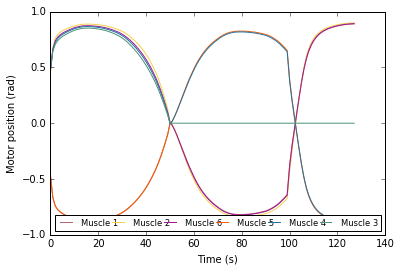

In [41]:
plot_data(data)

In [ ]:
# clearly the amplitude of the DEP output is significantly amplified by a better sensory delay history
# which makes sense due to the oscillations arising from the differences of the current and past sensory values

### But this is going too square; we need to reduce the amplitude

In [49]:
filename = "front_back.dep"
matrix_fb = loadDepMatrix(filename).reshape(1,14,28)

d = 50
pos_delayed = bases["fb"][0][-d:]/100000.
force_delayed = (bases["fb"][2][-d:]*0.2375-5)/300.
in_delayed = list((pos_delayed+force_delayed))

data = []
pos = bases["fb"][0][0]/100000.
force = (bases["fb"][2][0]*0.2375-5)/300.
in_ = pos+force
matrix = matrix_fb
for t in range(bases["fb"][0].shape[0]):
    sensors = np.append(in_,in_delayed[0]).reshape(1,28)
    in_ = dep_out(sensors,matrix).reshape(14,)
    in_delayed.pop(0)
    in_delayed.append(in_*0.5)
    data.append(in_)
data = np.array(data)

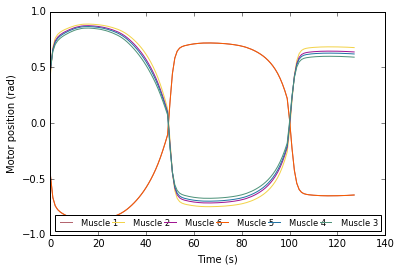

In [50]:
plot_data(data)

### Lets make this happen with the arm

65


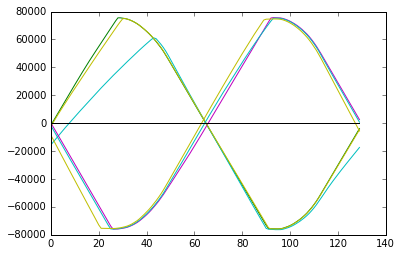

In [28]:
# Need to transform base data to vector or muscle states
id_ = "fs"
period = len(bases[id_][0][:])/2
print period
pos = bases[id_][0][:]
plt.plot(pos)
plt.show()